In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
reviews_df = pd.read_csv("Zomato Restaurant reviews (1).csv")
metadata_df = pd.read_csv("Zomato Restaurant names and Metadata (1).csv")

print("Reviews shape:", reviews_df.shape)
print("Metadata shape:", metadata_df.shape)

Reviews shape: (10000, 7)
Metadata shape: (105, 6)


In [9]:
#  Merge Data
merged_df = reviews_df.merge(metadata_df, left_on='Restaurant', right_on='Name', how='left')
print("Merged shape:", merged_df.shape)

Merged shape: (10000, 13)


In [11]:
#  Basic Cleaning: Ratings & Cost

merged_df['Rating_numeric'] = pd.to_numeric(merged_df['Rating'], errors='coerce')
merged_df['Cost_numeric'] = merged_df['Cost'].str.replace(',', '').astype(float)

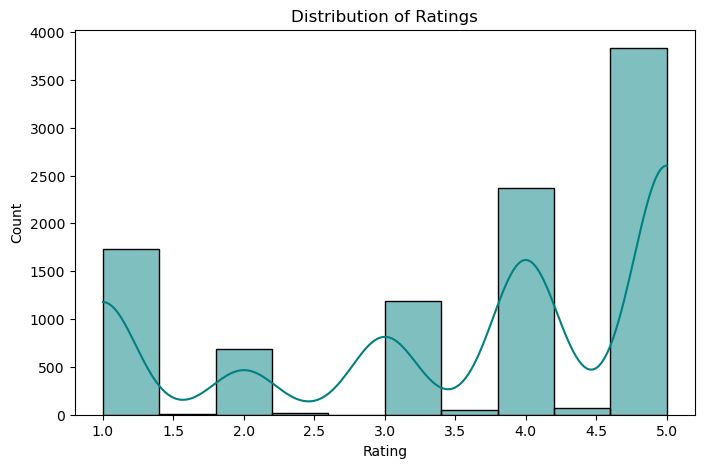

In [13]:
# . EDA: Plot Rating distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_df['Rating_numeric'].dropna(), bins=10, kde=True, color='teal')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [15]:
#Top 10 Cuisines
all_cuisines = merged_df['Cuisines'].dropna().str.split(', ')
flat_cuisines = list(itertools.chain.from_iterable(all_cuisines))
cuisine_counts = Counter(flat_cuisines)
top_cuisines = dict(cuisine_counts.most_common(10))

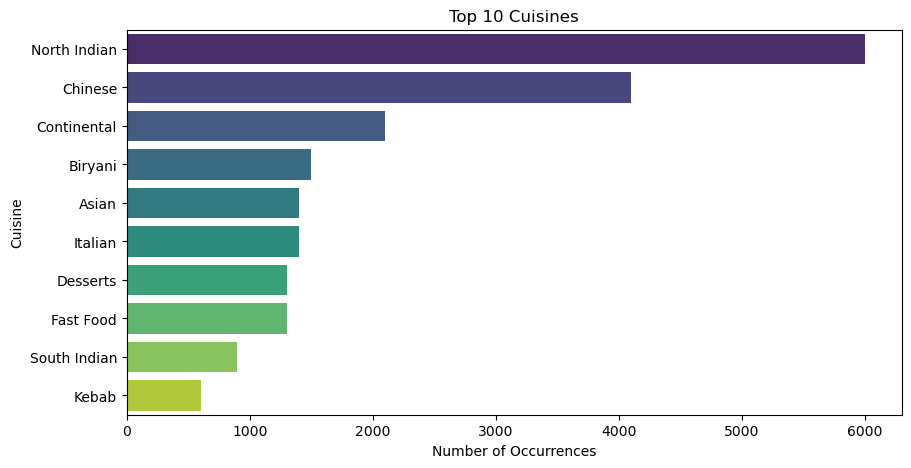

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(top_cuisines.values()), y=list(top_cuisines.keys()), palette='viridis')
plt.title('Top 10 Cuisines')
plt.xlabel('Number of Occurrences')
plt.ylabel('Cuisine')
plt.show()

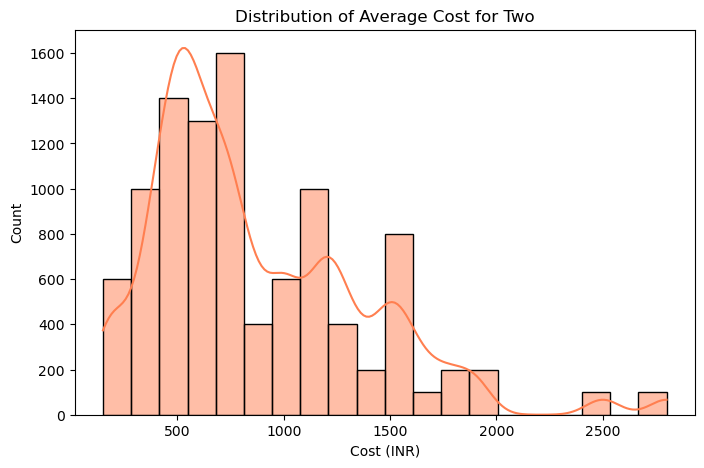

In [21]:
#Cost distribution
plt.figure(figsize=(8,5))
sns.histplot(merged_df['Cost_numeric'].dropna(), bins=20, kde=True, color='coral')
plt.title('Distribution of Average Cost for Two')
plt.xlabel('Cost (INR)')
plt.ylabel('Count')
plt.show()

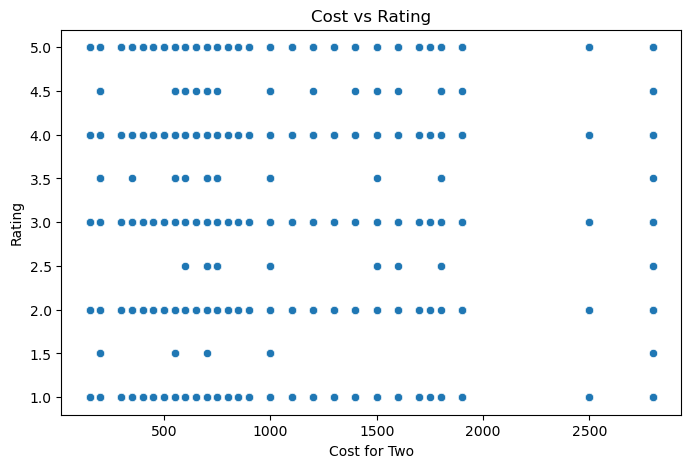

In [23]:
# Hypothesis Example:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x='Cost_numeric', y='Rating_numeric')
plt.title('Cost vs Rating')
plt.xlabel('Cost for Two')
plt.ylabel('Rating')
plt.show()

In [25]:
# Feature Engineering

In [27]:
# Drop rows with no rating
clean_df = merged_df.dropna(subset=['Rating_numeric'])

In [29]:
# Add Review length
clean_df['Review_Length'] = clean_df['Review'].fillna('').apply(len)

In [31]:
# Has pictures: 0/1
clean_df['Has_Pictures'] = clean_df['Pictures'].apply(lambda x: 1 if x > 0 else 0)

In [33]:
# Use first cuisine only
clean_df['Main_Cuisine'] = clean_df['Cuisines'].str.split(',').str[0]

In [45]:
from sklearn.preprocessing import OneHotEncoder

# Newer sklearn: use sparse_output
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [51]:
# Fit encoder
cuisine_encoded = encoder.fit_transform(clean_df[['Main_Cuisine']])

#  Use SAME feature name
cuisine_df = pd.DataFrame(
    cuisine_encoded, 
    columns=encoder.get_feature_names_out(['Main_Cuisine'])
).reset_index(drop=True)

# Combine
numeric_features = clean_df[['Cost_numeric', 'Review_Length', 'Has_Pictures']].reset_index(drop=True)
features_df = pd.concat([numeric_features, cuisine_df], axis=1)
target = clean_df['Rating_numeric'].reset_index(drop=True)

print(" Features shape:", features_df.shape)
print(" Target shape:", target.shape)


 Features shape: (9961, 34)
 Target shape: (9961,)


In [53]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)


In [55]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [57]:
#  Predict & Evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 1.44
R²: 0.06


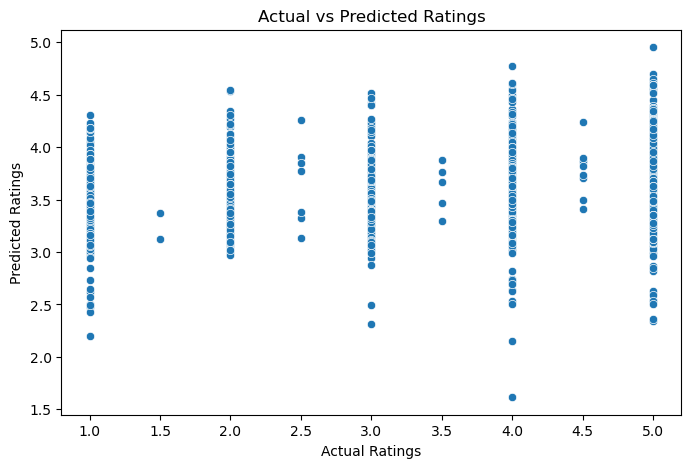

In [59]:
#  Actual vs Predicted plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()

# Ratings are generally high
The distribution of ratings shows most customers give 4–5 stars.

Very few restaurants or reviews fall below 3.

This suggests review bias — satisfied customers are more likely to leave a review.

# Cuisines show popularity trends
Top 10 cuisines include common ones like:

North Indian, Chinese, Continental, Fast Food, etc.

Some cuisines may attract higher average ratings than others — for example, niche or specialty cuisines often get slightly higher ratings due to unique offerings.

# Cost and Ratings correlation
Scatter plots show a weak positive trend:

Restaurants with higher average costs for two people tend to get slightly better ratings.

This may reflect better service, ambiance, or food quality at premium price points.

But the correlation isn’t very strong — price alone doesn’t fully predict rating.

# Pictures & Review Length
Restaurants with more pictures attached to reviews could signal higher engagement — you engineered Has_Pictures as a binary feature.

Longer reviews may indicate more thoughtful feedback — so Review_Length is an important feature for your model.

# Model Performance
A basic Linear Regression model using Cost, Review Length, Pictures, 

A reasonable RMSE: measures how far predicted ratings are from actual ratings.

A moderate R²: shows  some variance, but not all.
